<img src="NotebookAddons/blackboard-banner.png" width="100%" />
<font face="Calibri">
<br>
<font size="5"><b>Subset Data Stack</b><img style="padding: 7px" src="NotebookAddons/UAFLogo_A_647.png" width="170" align="right"/></font>

<br>
<font size="4"> <b>Alex Lewandowski; University of Alaska Fairbanks</b> <br>
</font>

<font size="3"> This notebook crops a directory of tiffs to a subset area of interest using an interactive Matplotlib plot of an image in your data stack.
<font>
</font>

<hr>
<font face="Calibri" size="5" color="darkred"> <b>Important Note about JupyterHub</b> </font>
<br><br>
<font face="Calibri" size="3"> <b>Your JupyterHub server will automatically shutdown when left idle for more than 1 hour. Your notebooks will not be lost but you will have to restart their kernels and re-run them from the beginning. You will not be able to seamlessly continue running a partially run notebook.</b> </font>


<hr>
<font face="Calibri">

<font size="5"> <b> 0. Importing Relevant Python Packages </b> </font>

<font size="3">In this notebook we will use the following scientific library:
<ol type="1">
    <li> <b><a href="https://www.gdal.org/" target="_blank">GDAL</a></b> is a software library for reading and writing raster and vector geospatial data formats. It includes a collection of programs tailored for geospatial data processing. Most modern GIS systems (such as ArcGIS or QGIS) use GDAL in the background.</li>

</font>


<font face="Calibri" size="3"><b>Import the necesssary libraries and modules:</b> </font>

In [1]:
%%capture
import os
os.environ["PROJ_LIB"] = '/opt/conda/share/proj/'
import glob
import json # for loads
import shutil

from osgeo import gdal
import pyproj 
import numpy as np

from IPython.display import Markdown
from IPython.display import display

from matplotlib.widgets import RectangleSelector
import matplotlib.pyplot as plt 
plt.rcParams.update({'font.size': 12})

from asf_notebook import new_directory
from asf_notebook import path_exists
from asf_notebook import remove_nan_filled_tifs
from asf_notebook import AOI_Selector
from asf_notebook import select_parameter
from asf_notebook import get_polarity_from_path
from asf_notebook import date_from_product_name
from asf_notebook import jupytertheme_matplotlib_format


<font face="Calibri" size="3"><b>Setup interactive Matplotlib plotting</b> inside the notebook:</font>

In [2]:
%%capture
jupytertheme_matplotlib_format()
%matplotlib notebook

<hr>
<font face="Calibri" size="3"><b>Write functions to gather and print individual tiff paths:</b> </font>

In [3]:
def get_tiff_paths(paths):
    tiff_paths = glob.glob(paths)
    tiff_paths.sort()
    return tiff_paths

def print_tiff_paths(tiff_paths):
    print("Tiff paths:")
    for p in tiff_paths:
        print(f"{p}\n")

<font face="Calibri" size="3"><b>Enter the path to the directory holding your tiffs:</b> </font>

In [4]:
# /home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/tiffs
while True:
    print("Enter the absolute path to the directory holding your tiffs.")
    tiff_dir = input()
    paths = f"{tiff_dir}/*.tif*"
    if os.path.exists(tiff_dir):
        tiff_paths = get_tiff_paths(paths)
        if len(tiff_paths) < 1:
            print(f"{tiff_dir} exists but contains no tifs.")
            print("You will not be able to proceed until tifs are prepared.")
        break
    else:
        print(f"\n{tiff_dir} does not exist.")
        continue

Enter the absolute path to the directory holding your tiffs.
/home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/tiffs


<font face="Calibri" size="3"><b>Determine the path to the analysis directory containing the tiff directory:</b> </font>

In [5]:
analysis_dir = os.path.dirname(tiff_dir)
print(analysis_dir)

/home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer


<font face="Calibri" size="3"><b>Determine the UTM zone for your images.</b> This assumes you have already reprojected any tiffs with errant UTM zones to a single predominant UTM zone, using the Prepare_Data_Stack_Hyp3 notebook.</font>

In [18]:
info = (gdal.Info(tiff_paths[0], options = ['-json']))
info = json.dumps(info)
info = (json.loads(info))['coordinateSystem']['wkt']
utm = info.split('ID')[-1].split(',')[1][0:-2]
print(f"UTM Zone: {utm}")

UTM Zone: 32648


In [19]:
tiff_paths = get_tiff_paths(paths)
print_tiff_paths(tiff_paths)

Tiff paths:
/home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/tiffs/newS1A_IW_20180619T110424_DVP_RTC30_G_gpufem_3794_VH.tif

/home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/tiffs/newS1A_IW_20180619T110424_DVP_RTC30_G_gpufem_3794_VV.tif

/home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/tiffs/newS1A_IW_20180623T224352_DVP_RTC30_G_gpufem_B6E7_VH.tif

/home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/tiffs/newS1A_IW_20180623T224352_DVP_RTC30_G_gpufem_B6E7_VV.tif

/home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/tiffs/newS1A_IW_20180701T110424_DVP_RTC30_G_gpufem_B835_VH.tif

/home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/tiffs/newS1A_IW_20180701T110424_DVP_RTC30_G_gpufem_B835_VV.tif

/home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/tiffs/newS1A_IW_20180705T224418_DVP_RTC30_G_gpufem_0C30_VH.tif

/home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/tiffs/newS1A_IW_20180705T224

<font size="3"> <b>Create a string containing paths to one image for each area represented in the stack:</b> </font> 

In [20]:
to_merge = {}
for pth in tiff_paths:
    info = (gdal.Info(pth, options = ['-json']))
    info = json.dumps(info)
    info = (json.loads(info))['wgs84Extent']['coordinates']
    
    coords = [info[0][0], info[0][3]]
    for i in range(0, 2):
        for j in range(0, 2):
            coords[i][j] = round(coords[i][j])
    str_coords = f"{str(coords[0])}{str(coords[1])}"
    if str_coords not in to_merge:
        to_merge.update({str_coords: pth})
merge_paths = ""
for pth in to_merge:
    merge_paths = f"{merge_paths} {to_merge[pth]}"
print(merge_paths)

 /home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/tiffs/newS1A_IW_20180619T110424_DVP_RTC30_G_gpufem_3794_VH.tif /home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/tiffs/newS1A_IW_20180623T224352_DVP_RTC30_G_gpufem_B6E7_VH.tif


<font face="Calibri" size="3"><b>Merge the images for display in the Area-Of-Interest selector:</b></font>

In [9]:
full_scene = f"{analysis_dir}/full_scene.tif"
if os.path.exists(full_scene):
    os.remove(full_scene)
gdal_command = f"gdal_merge.py -o {full_scene} {merge_paths}"
!{gdal_command}

0...10...20...30...40...50...60...70...80...90...100 - done.


<hr>
<font face="Calibri">

<font size="5"> <b>Subset The Tiffs</b> </font> 

</font>

<font face="Calibri" size="3"><b>Create a Virtual Raster Stack:</b> </font>

In [10]:
image_file = f"{analysis_dir}/raster_stack.vrt"
!gdalbuildvrt -separate $image_file -overwrite $full_scene

0...10...20...30...40...50...60...70...80...90...100 - done.


<font face="Calibri" size="3"><b>Convert the VRT into an array:</b> </font>

In [11]:
img = gdal.Open(image_file)
rasterstack = img.ReadAsArray()

<font face="Calibri" size="3"><b>Print the number of bands, pixels, and lines:</b> </font>

In [12]:
print(img.RasterCount) # Number of Bands
print(img.RasterXSize) # Number of Pixels
print(img.RasterYSize) # Number of Lines

1
10770
12743


<font face="Calibri" size="3"><b>Create an AOI selector from an image in your raster stack:</b> </font>

<text style=color:blue><b>Area of Interest Selector Tips:
</b></text>

<text style=color:blue>- This plot uses "matplotlib notebook", whereas the other plots in this notebook use "matplotlib inline".</text>

<text style=color:blue>-  If you run this cell out of sequence and the plot is not interactive, rerun the "%matplotlib notebook" code cell.</text>

<text style=color:blue>- Use the pan tool to pan with the left mouse button.</text>

<text style=color:blue>- Use the pan tool to zoom with the right mouse button.</text>

<text style=color:blue>- You can also zoom with a selection box using the zoom to rectangle tool.</text>

<text style=color:blue>- To turn off the pan or zoom to rectangle tool so you can select an AOI, click the selected tool button again.</text>

<text style=color:darkred><b>IMPORTANT!</b></text>

<text style=color:darkred>- Upon loading the AOI selector, the selection tool is already active.</text>

<text style=color:darkred>- Click, drag, and release the left mouse button to select an area.</text>

<text style=color:darkred>- The square tool icon in the menu is <b>NOT</b> the selection tool. It is the zoom tool.</text>

<text style=color:darkred>- If you select any tool, you must toggle it off before you can select an AOI</text>

<IPython.core.display.Javascript object>


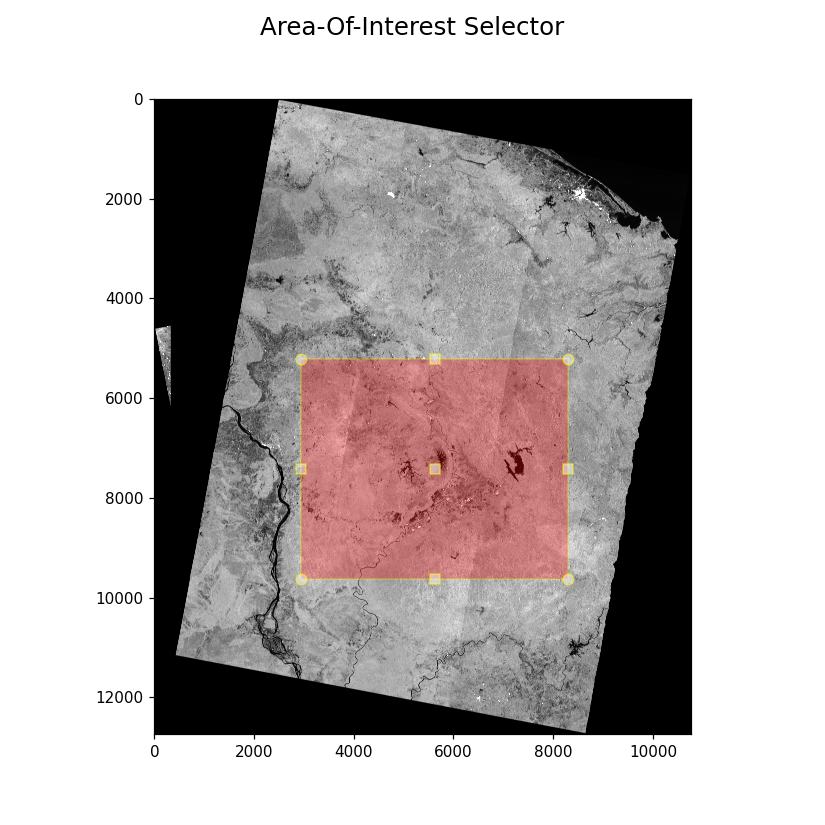

In [14]:
fig_xsize = 7.5
fig_ysize = 7.5
aoi = AOI_Selector(rasterstack, fig_xsize, fig_ysize)

<font face="Calibri" size="3"><b>Gather and define projection details:</b> </font>

In [21]:
geotrans = img.GetGeoTransform()
projlatlon = pyproj.Proj('EPSG:4326') # WGS84
projimg = pyproj.Proj(f'EPSG:{utm}')

<font face="Calibri" size="3"><b>Write a function to convert the pixel, line coordinates from the AOI selector into geographic coordinates in the stack's EPSG projection:</b> </font>

In [22]:
def geolocation(x, y, geotrans,latlon=True):
    ref_x = geotrans[0]+x*geotrans[1]
    ref_y = geotrans[3]+y*geotrans[5]
    if latlon:
        ref_y, ref_x = pyproj.transform(projimg, projlatlon, ref_x, ref_y)
    return [ref_x, ref_y]

<font face="Calibri" size="3"><b>Call geolocation to gather the aoi_coords:</b> </font>

In [23]:
try:
    aoi_coords = [geolocation(aoi.x1, aoi.y1, geotrans, latlon=False), geolocation(aoi.x2, aoi.y2, geotrans, latlon=False)]
    print(f"aoi_coords in EPSG {utm}: {aoi_coords}")
except TypeError:
    print('TypeError')
    display(Markdown(f'<text style=color:red>This error occurs if an AOI was not selected.</text>'))
    display(Markdown(f'<text style=color:red>Note that the square tool icon in the AOI selector menu is <b>NOT</b> the selection tool. It is the zoom tool.</text>'))
    display(Markdown(f'<text style=color:red>Read the tips above the AOI selector carefully.</text>'))

aoi_coords in EPSG 32648: [[607882.2025447697, 1724121.6845690133], [768079.9168304839, 1591726.8793742082]]


<font face="Calibri" size="3"><b>Collect the paths to the tiffs:</b> </font>

In [24]:
tiff_paths = get_tiff_paths(paths)
#print_tiff_paths(tiff_paths)

<font face="Calibri" size="3"><b>Create a subdirectory in which to store the subset tiffs:</b> </font>

In [26]:
# subset_tiffs
print("Choose a directory name in which to store the subset geotiffs.")
print("Note: this will sit alongside the directory containing your pre-subset geotiffs.")
while True:
    sub_name = input()
    if sub_name == "":
        print("Please enter a valid directory name")
        continue
    else:
        break

Choose a directory name in which to store the subset geotiffs.
Note: this will sit alongside the directory containing your pre-subset geotiffs.
subset_tiffs


<font size="3"><b>Subset the tiffs and move them from the individual product directories into their own directory, /tiffs:</b></font> 

In [27]:
tiff_paths = get_tiff_paths(paths)
for p in tiff_paths:
    print(p)

/home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/tiffs/newS1A_IW_20180619T110424_DVP_RTC30_G_gpufem_3794_VH.tif
/home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/tiffs/newS1A_IW_20180619T110424_DVP_RTC30_G_gpufem_3794_VV.tif
/home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/tiffs/newS1A_IW_20180623T224352_DVP_RTC30_G_gpufem_B6E7_VH.tif
/home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/tiffs/newS1A_IW_20180623T224352_DVP_RTC30_G_gpufem_B6E7_VV.tif
/home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/tiffs/newS1A_IW_20180701T110424_DVP_RTC30_G_gpufem_B835_VH.tif
/home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/tiffs/newS1A_IW_20180701T110424_DVP_RTC30_G_gpufem_B835_VV.tif
/home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/tiffs/newS1A_IW_20180705T224418_DVP_RTC30_G_gpufem_0C30_VH.tif
/home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/tiffs/newS1A_IW_20180705T224418_DVP_RTC30_G_gpu

In [28]:
subset_dir = f"{analysis_dir}/{sub_name}/"
new_directory(subset_dir)
for i, tiff_path in enumerate(tiff_paths):
    print(tiff_path)
    date = os.path.basename(date_from_product_name(tiff_path)).split('T')[0]
    polar = get_polarity_from_path(tiff_path)
    print(f"\nProduct #{i+1}:")
    gdal_command = f"gdal_translate -projwin {aoi_coords[0][0]} {aoi_coords[0][1]} {aoi_coords[1][0]} {aoi_coords[1][1]} -projwin_srs 'EPSG:{utm}' -co \"COMPRESS=DEFLATE\" -a_nodata 0 {tiff_path} {subset_dir}{date}_{polar}.tiff"
    print(f"Calling the command: {gdal_command}")
    !{gdal_command}

Created: /home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/subset_tiffs/
/home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/tiffs/newS1A_IW_20180619T110424_DVP_RTC30_G_gpufem_3794_VH.tif

Product #1:
Calling the command: gdal_translate -projwin 607882.2025447697 1724121.6845690133 768079.9168304839 1591726.8793742082 -projwin_srs 'EPSG:32648' -co "COMPRESS=DEFLATE" -a_nodata 0 /home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/tiffs/newS1A_IW_20180619T110424_DVP_RTC30_G_gpufem_3794_VH.tif /home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/subset_tiffs/20180619_VH.tiff
Input file size is 9604, 7299
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/tiffs/newS1A_IW_20180619T110424_DVP_RTC30_G_gpufem_3794_VV.tif

Product #2:
Calling the command: gdal_translate -projwin 607882.2025447697 1724121.6845690133 768079.9168304839 1591726.8793742082 -projwin_srs 'EPSG:326

Input file size is 9604, 7299
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/tiffs/newS1A_IW_20180725T110426_DVP_RTC30_G_gpufem_7178_VV.tif

Product #14:
Calling the command: gdal_translate -projwin 607882.2025447697 1724121.6845690133 768079.9168304839 1591726.8793742082 -projwin_srs 'EPSG:32648' -co "COMPRESS=DEFLATE" -a_nodata 0 /home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/tiffs/newS1A_IW_20180725T110426_DVP_RTC30_G_gpufem_7178_VV.tif /home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/subset_tiffs/20180725_VV.tiff
Input file size is 9604, 7299
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/tiffs/newS1A_IW_20180729T224419_DVP_RTC30_G_gpufem_5C27_VH.tif

Product #15:
Calling the command: gdal_translate -projwin 607882.2025447697 1724121.6845690133 768079.9168304839 1591726.8793742082 -projwin_srs 'EP

<font size="3"><b>Delete any subset tifs that are filled with NaNs and contain no data.</b></font>

In [29]:
subset_paths = f"{subset_dir}*.tif*"
tiff_paths = get_tiff_paths(subset_paths)
remove_nan_filled_tifs(subset_dir, tiff_paths)

GeoTiffs Examined: 20
GeoTiffs Removed:  0


<font size="3"><b>Sometimes, when using gdal translate to subset a stack of images, there will be slight differences in sizes of the resulting images, off by a single pixel in either direction. The following code checks the newly subset stack for this problem, and if found, it re-subsets all the images to the size of the smallest image in the stack.</b></font>

In [ ]:
corners = [gdal.Info(tiff_paths[0], format='json')['cornerCoordinates']['upperLeft'],
                 gdal.Info(tiff_paths[0], format='json')['cornerCoordinates']['lowerRight']]
sizes = list()
for p in tiff_paths:
    info = gdal.Info(p, format='json')
    sizes.append((info['size'][0], info['size'][1]))
    corners = [[max(corners[0][0], gdal.Info(tiff_paths[0], format='json')['cornerCoordinates']['upperLeft'][0]),
               min(corners[0][1], gdal.Info(tiff_paths[0], format='json')['cornerCoordinates']['upperLeft'][1])],
               [min(corners[1][0], gdal.Info(tiff_paths[0], format='json')['cornerCoordinates']['lowerRight'][0]),
               max(corners[1][1], gdal.Info(tiff_paths[0], format='json')['cornerCoordinates']['lowerRight'][1])]]
if len(sizes) != len(set(sizes)):
    print(set(sizes))
    print(corners)
    temp_path = f"{analysis_dir}/temp_subsetting"
    if not os.path.exists(temp_path):
        os.rename(subset_dir, temp_path)
        os.mkdir(subset_dir)
        tiff_paths = glob.glob(f"{temp_path}/*.tif*")

    for i, tiff_path in enumerate(tiff_paths):
        print(f"\nProduct #{i+1}:")
        gdal_command = f"gdal_translate -projwin {corners[0][0]} {corners[0][1]} {corners[1][0]} {corners[1][1]} -projwin_srs 'EPSG:{utm}' -co \"COMPRESS=DEFLATE\" -a_nodata 0 {tiff_path} {subset_dir}{os.path.basename(tiff_path)}"
        print(f"Calling the command: {gdal_command}")
        !{gdal_command}
    shutil.rmtree(temp_path)

{(5340, 4413)}
[[607860.0, 1724130.0], [768060.0, 1591740.0]]

Product #1:
Calling the command: gdal_translate -projwin 607860.0 1724130.0 768060.0 1591740.0 -projwin_srs 'EPSG:32648' -co "COMPRESS=DEFLATE" -a_nodata 0 /home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/temp_subsetting/20180717_VH.tiff /home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/subset_tiffs/20180717_VH.tiff
Input file size is 5340, 4413
0...10...20...30...40...50...60...70...80...90...100 - done.

Product #2:
Calling the command: gdal_translate -projwin 607860.0 1724130.0 768060.0 1591740.0 -projwin_srs 'EPSG:32648' -co "COMPRESS=DEFLATE" -a_nodata 0 /home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/temp_subsetting/20180806_VV.tiff /home/jovyan/notebooks/ASF/GEOS_657_Project/gamma0_100km_buffer/subset_tiffs/20180806_VV.tiff
Input file size is 5340, 4413
0...10...20...30...40...50...60...70...80...90...100 - done.

Product #3:
Calling the command: gdal_translate -projwin 60

<font size="3"><b>Decide whether or not to cleanup the original tiffs:</b></font> 

In [ ]:
cleanup = select_parameter(["Save original tiffs", "Delete original tiffs"], '')
cleanup

In [ ]:
if cleanup.value == 'Delete original tiffs':
    shutil.rmtree(tiff_dir)

<font size="3"><b>Print the path to your subset directory:</b></font> 

In [ ]:
print(subset_dir[:-1])

<font face="Calibri" size="2"> <i>GEOS 657 Microwave Remote Sensing - Version 1.4 - December 2020 
    <br>
        <b>Version Changes:</b>
    <ul>
        <li>Handle gdal translate issue in which some image dimensions in subset stack off by 1 pixel</li>
    </ul>
    </i>
</font>